In [ ]:
# 1. Mount Google Drive to save model later
from google.colab import drive
drive.mount('/content/drive')

# 2. Upload kaggle.json (your Kaggle API token)
from google.colab import files
print("Upload your kaggle.json API token now:")
files.upload()  # Upload kaggle.json here

# 3. Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download the dataset you shared
!kaggle datasets download -d landrykezebou/vcor-vehicle-color-recognition-dataset

# 5. Unzip it
!unzip -q vcor-vehicle-color-recognition-dataset.zip -d ./vcor_dataset

# 6. Check folder structure and set train/val paths dynamically
import os

base_dir = './vcor_dataset'
train_path, val_path = None, None

for root, dirs, files in os.walk(base_dir):
    if 'train' in dirs:
        train_path = os.path.join(root, 'train')
    if 'val' in dirs:
        val_path = os.path.join(root, 'val')

print(f"✅ Train path detected: {train_path}")
print(f"✅ Val path detected: {val_path}")

if not train_path or not val_path:
    raise Exception("❌ Train or val folders not found. Please check the extracted folder structure.")

# 7. Install required packages (if needed)
!pip install -q torch torchvision

# 8. Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# 9. Define data transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 10. Load datasets
train_dataset = datasets.ImageFolder(train_path, transform=transform_train)
val_dataset = datasets.ImageFolder(val_path, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)
print(f"✅ Number of classes: {num_classes}")
print(f"✅ Classes: {train_dataset.classes}")

# 11. Load pretrained ResNet50 and modify final layer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# 12. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 13. Training loop with saving after each epoch
num_epochs = 5  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"✅ Epoch {epoch+1}/{num_epochs} — Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # 🔵 Save model after each epoch
    epoch_save_path = f'/content/drive/MyDrive/vcor_resnet50_epoch{epoch+1}.pth'
    torch.save(model.state_dict(), epoch_save_path)
    print(f"💾 Model saved after epoch {epoch+1} to {epoch_save_path}")

# 14. Save final trained model to Google Drive
final_save_path = '/content/drive/MyDrive/vcor_finetuned_resnet50_final.pth'
torch.save(model.state_dict(), final_save_path)
print(f"✅ Final PyTorch model saved to {final_save_path}")

# 15. Convert to TorchScript for Raspberry Pi deployment
example = torch.rand(1, 3, 224, 224).to(device)
traced_script_module = torch.jit.trace(model, example)
torchscript_path = '/content/drive/MyDrive/vcor_finetuned_scripted.pt'
traced_script_module.save(torchscript_path)
print(f"✅ TorchScript model saved to {torchscript_path}")


Mounted at /content/drive
Upload your kaggle.json API token now:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/landrykezebou/vcor-vehicle-color-recognition-dataset
License(s): copyright-authors
 91% 524M/574M [00:02<00:00, 203MB/s]
100% 574M/574M [00:06<00:00, 91.8MB/s]
✅ Train path detected: ./vcor_dataset/train
✅ Val path detected: ./vcor_dataset/val
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


✅ Epoch 1/5 — Loss: 0.7519, Accuracy: 75.07%
💾 Model saved after epoch 1 to /content/drive/MyDrive/vcor_resnet50_epoch1.pth
✅ Epoch 2/5 — Loss: 0.4292, Accuracy: 85.29%
💾 Model saved after epoch 2 to /content/drive/MyDrive/vcor_resnet50_epoch2.pth
✅ Epoch 3/5 — Loss: 0.2882, Accuracy: 90.02%
💾 Model saved after epoch 3 to /content/drive/MyDrive/vcor_resnet50_epoch3.pth
✅ Epoch 4/5 — Loss: 0.2252, Accuracy: 92.71%
💾 Model saved after epoch 4 to /content/drive/MyDrive/vcor_resnet50_epoch4.pth
✅ Epoch 5/5 — Loss: 0.1778, Accuracy: 94.11%
💾 Model saved after epoch 5 to /content/drive/MyDrive/vcor_resnet50_epoch5.pth
✅ Final PyTorch model saved to /content/drive/MyDrive/vcor_finetuned_resnet50_final.pth
✅ TorchScript model saved to /content/drive/MyDrive/vcor_finetuned_scripted.pt


In [ ]:
# Install Kaggle if needed
!pip install -q kaggle

# Upload kaggle.json for Kaggle API authentication
from google.colab import files
files.upload()  # Upload your kaggle.json here

# Setup Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d landrykezebou/vcor-vehicle-color-recognition-dataset

# Unzip the dataset
!unzip -q vcor-vehicle-color-recognition-dataset.zip -d ./vcor_dataset

# Check folder structure
!ls ./vcor_dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/landrykezebou/vcor-vehicle-color-recognition-dataset
License(s): copyright-authors
 88% 503M/574M [00:03<00:01, 69.6MB/s]
100% 574M/574M [00:03<00:00, 185MB/s] 
test  train  val


Mounted at /content/drive
✅ Classes used in training: ['beige', 'black', 'blue', 'brown', 'gold', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'silver', 'tan', 'white', 'yellow']
✅ Number of classes: 15
✅ Using device: cpu


Saving mulcar.jpg to mulcar.jpg
✅ Uploaded image: mulcar.jpg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🎨 Predicted car colour: blue (27.27% confidence)


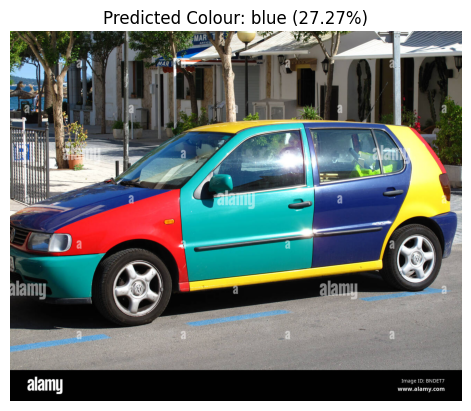

In [ ]:
# ===============================
# 🚀 FULL INFERENCE SCRIPT USING TRAINING DATA CLASSES
# ===============================

from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torchvision import models, datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from google.colab import drive, files
import os

# 1. Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# 2. Define dataset folder (adjust if needed)
train_path = '/content/vcor_dataset/train'  # Change to your actual train folder path

# 3. Load training dataset to get classes
train_dataset = datasets.ImageFolder(train_path)
colour_labels = train_dataset.classes
num_classes = len(colour_labels)

print(f"✅ Classes used in training: {colour_labels}")
print(f"✅ Number of classes: {num_classes}")

# 4. Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# 5. Upload an image for testing
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"✅ Uploaded image: {image_path}")

# 6. Define preprocessing transform (match training preprocessing)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet normalization
                         std=[0.229, 0.224, 0.225])
])

# 7. Load and preprocess the image
image = Image.open(image_path).convert('RGB')
input_tensor = test_transform(image).unsqueeze(0).to(device)  # Add batch dim

# 8. Load model architecture and weights
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

model_path = '/content/drive/MyDrive/vcor_finetuned_resnet50_final.pth'  # Change if needed
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 9. Predict with confidence
with torch.no_grad():
    outputs = model(input_tensor)
    probs = F.softmax(outputs, dim=1)
    top_prob, top_class = torch.max(probs, 1)

predicted_colour = colour_labels[top_class.item()]
confidence = top_prob.item() * 100

print(f"🎨 Predicted car colour: {predicted_colour} ({confidence:.2f}% confidence)")

# 10. Show image with prediction title
plt.imshow(image)
plt.title(f"Predicted Colour: {predicted_colour} ({confidence:.2f}%)")
plt.axis('off')
plt.show()


In [ ]:
import json
from google.colab import files

# Save the class labels from your training dataset
with open("vcor_classes.json", "w") as f:
    json.dump(train_dataset.classes, f)

# Download the file to your local machine
files.download("vcor_classes.json")


NameError: name 'train_dataset' is not defined